# Simple Coordination Comparision with Batch Algorithm Figure

Uncomment the following cells (by deleting the leading `#`) if you are running this in Colab.

In [ ]:
# !git clone https://github.com/wbarfuss/POLD.git

In [ ]:
# !pip install pyDOE

In [ ]:
# cd POLD

In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from agents.deterministic import detQ
from agents.batchQ import batchQ, get_softmax_policy
from environments.Env_2StateSingh import TwoStateSingh as ENV

from utils import interact as ia
from utils import quiver as qv

# document this session for reproducibility
import IPython
print(IPython.sys_info())
print()
print('PACKAGES')
print('----- pip -----')
!pip freeze | grep -E 'numpy|scipy|pandas|matplotlib|ipython|pyDOE'
print('----- conda -----')
!conda list --export | grep -E 'numpy|scipy|pandas|matplotlib|ipython|pyDOE'

{'commit_hash': '8648ed8d7',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/Users/wolf/.miniconda3/envs/RRL/lib/python3.9/site-packages/IPython',
 'ipython_version': '7.22.0',
 'os_name': 'posix',
 'platform': 'macOS-10.16-x86_64-i386-64bit',
 'sys_executable': '/Users/wolf/.miniconda3/envs/RRL/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.9.5 (default, May 18 2021, 12:31:01) \n[Clang 10.0.0 ]'}

PACKAGES
----- pip -----
ipython @ file:///opt/concourse/worker/volumes/live/53a0fafb-1ff1-44d4-4ba9-874c42807e28/volume/ipython_1617120878135/work
ipython-genutils @ file:///tmp/build/80754af9/ipython_genutils_1606773439826/work
matplotlib @ file:///opt/concourse/worker/volumes/live/41e8cd50-031f-4dda-5787-dd3c4f4e0f08/volume/matplotlib-suite_1613407855571/work
numpy==1.22.2
pandas==1.4.1
pyDOE==0.3.8
scipy==1.8.0
----- conda -----
ipython=7.22.0=py39h01d92e1_0
ipython_genutils=0.2.0=pyhd3eb1b0_1
matplotlib=3.3.4=py39hecd8cb5_0
matplotlib-base=

In [2]:
# test initialization
gamma = 0.9
beta = 40 / (1-gamma)
alpha = 0.01

NOISE = 0.4

env = ENV(**dict(obs_noise=NOISE))
T, R, O = env.T, env.R, env.O
assert np.allclose(T.sum(-1), 1)
assert np.allclose(O.sum(-1), 1)

agents = detQ(T, R, O, alpha, beta, gamma)
print(f"Agent with parameters alpha={alpha}, beta={beta}, gamma={gamma}")

Agent with parameters alpha=0.01, beta=400.0000000000001, gamma=0.9


In [8]:
# Compute deterministic trajectory
X0 = np.array([[[0.3, 0.7], [0.3, 0.7]]])

start_time = time.time()    
Xtraj, Rtraj, fpr = ia.compute_detXtraj(agents, X0, EpsMin=1e-5, Tmax=26)
end_time = time.time()

print('Computed deterministic trajectory in', end_time-start_time, 'seconds')

Computed deterministic trajectory in 0.11241388320922852 seconds


In [9]:
bsize = 128  # batchsize
learning_steps = 25

def compute_batch(bsize, learning_steps, X0, sampsize=5):
    Q0 = 1/beta * (np.log(X0) - np.log(X0).mean(-1, keepdims=True))

    # compute trajectories of the policy
    length =  bsize * learning_steps

    pol = get_softmax_policy(intensity_of_choice=beta)
    aparams = dict(learning_rate=alpha, discount_factor=gamma, batchsize=bsize)

    Xtrajs_batch = []
    print('Compute batch w bsize', bsize, ' sample: ', end=' ')
    for i in range(sampsize):
        algAs = [batchQ(Q0[0], policy_function=pol, **aparams)]
        dat = ia.interface(algAs, env, length)
        Xtrajs_batch.append(dat['policies'])
        print(i, end=' ')
    print()
    return np.array(Xtrajs_batch)
     
Xtrajs_batch128 = compute_batch(128, learning_steps, X0, sampsize=25)
Xtrajs_batch1024 = compute_batch(1024, learning_steps, X0, sampsize=5)

Compute batch w bsize 128  sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
Compute batch w bsize 1024  sample:  0 1 2 3 4 


### Plot

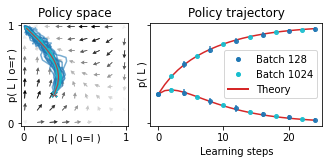

In [10]:
fsf = 0.7
fig = plt.figure(figsize=(fsf*6.5, fsf*3))
gs = fig.add_gridspec(1, 5, wspace=0.52, hspace=0.8, left=0.06, right=0.98,
                      top=0.89, bottom=0.21)

axPS = fig.add_subplot(gs[:2])
axTR = fig.add_subplot(gs[2:])

col128 = 'tab:blue'
col1024 = 'tab:cyan'
colDET = 'tab:red'

pAs = np.linspace(0.01, 0.99, 9)
x1=([0], [0], [0]); y1=([0], [1], [0])
axes= qv.plot_quiver(agents, x=x1, y=y1, diff="X",
                     pAs=pAs, NrRandom=8, kind="quiver+samples", dens=0.4,
                     sf=0.5, policies_iter_steps=0, axes=[axPS], cmap='Greys')

qv.plot_trajectories(Xtrajs_batch128, x1, y1, lss=["-"], lws=[1.5],
                     cols=[col128], alphas=[0.6], axes=axes)
qv.plot_trajectories(Xtrajs_batch1024, x1, y1, lss=["-"], lws=[2.0],
                     cols=[col1024], alphas=[0.95], axes=axes)
qv.plot_trajectories([Xtraj], x1, y1, lss=["-"], lws=[1.2], cols=[colDET], 
                     alphas=[0.8], axes=axes)


msize = 8  # markersize

axTR.errorbar(np.arange(0, 25)[0::4],
             Xtrajs_batch128[:, :-1:bsize, 0, 0, 0].mean(0)[0::4], 
             yerr=Xtrajs_batch128[:, :-1:bsize, 0, 0, 0].std(0)[0::4],
             marker='.', linestyle='', color=col128, markersize=msize,
             alpha=0.9)

axTR.errorbar(np.arange(0, 25)[0::4],
             Xtrajs_batch128[:, :-1:128, 0, 1, 0].mean(0)[0::4], 
             yerr=Xtrajs_batch128[:, :-1:128, 0, 1, 0].std(0)[0::4],
             marker='.', linestyle='', color=col128, markersize=msize,
             alpha=0.9)

axTR.errorbar(np.arange(0, 25)[2::4],
             Xtrajs_batch1024[:, :-1:1024, 0, 0, 0].mean(0)[2::4], 
             yerr=Xtrajs_batch1024[:, :-1:1024, 0, 0, 0].std(0)[2::4],
             marker='.', linestyle='', color=col1024, markersize=msize,
             alpha=0.9)

axTR.errorbar(np.arange(0, 25)[2::4],
             Xtrajs_batch1024[:, :-1:1024, 0, 1, 0].mean(0)[2::4], 
             yerr=Xtrajs_batch1024[:, :-1:1024, 0, 1, 0].std(0)[2::4],
             marker='.', linestyle='', color=col1024, markersize=msize,
             alpha=0.9)

axTR.plot(Xtraj[1:learning_steps+1,0, :, 0], zorder=0, color=colDET)

# Labeling
axTR.set_yticks(axPS.get_yticks())
axTR.set_ylim(axPS.get_ylim())
axTR.set_yticklabels([])
axTR.set_xlabel("Learning steps")
axTR.set_ylabel("p( L )", labelpad=-5)
axPS.set_xlabel("p( L | o=l )", labelpad=-10)
axPS.set_ylabel("p( L | o=r )", labelpad=-10)
axPS.set_title('Policy space')
axTR.set_title('Policy trajectory')

# Legend
ledli = [Line2D([0],[0], color=c, marker='.', markersize=8, linestyle='')
         for c in [col128, col1024]] +\
        [Line2D([0],[0], color=colDET, lw=2, linestyle='-')]

ledla = ['Batch 128', 'Batch 1024', 'Theory']
axTR.legend(ledli, ledla, loc="center right", bbox_to_anchor=(1.00, 0.5), 
            ncol=1)

# plt.savefig("figs/fig_SimpleCoordinationBatch.png", dpi=300)